In [ ]:
import my_utils as mu
import torch
from torch import nn
from IPython import display

## Loading the dataset

In [ ]:
batch_size = 256 #hyperparameter
train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
X, y = next(iter(train_iter)) #first batch
print(X.size())
#y is the output of the 256 images from the batch and the label represents the class for the image

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([256, 1, 28, 28])


## 1. Stem

### 1.1. Vectorizing the non overlapping patches

In [ ]:
#Splitting each image into 4 patches of 14*14 H*W

B, C, W, H = 256, 1, 28, 28
x = X

kernel_size = 2
stride = 2
patches = x.unfold(2, kernel_size, stride).unfold(3, kernel_size, stride)
print(patches.shape) # [B, C, nb_patches_h, nb_patches_w, kernel_size, kernel_size]

patches = patches.contiguous().view(B, C, -1, kernel_size*kernel_size)
print(patches.shape) # [B, C, nb_patches_all, kernel_size*kernel_size]
patches = patches.permute(0, 1, 3, 2) 
print(patches.shape) # [B, C, kernel_size*kernel_size, nb_patches_all]
patches = patches.contiguous().view(B, C*kernel_size*kernel_size, -1)
patches.shape # [B, C*prod(kernel_size), L]  

x = patches 
x.shape #Batches, Patches, HxW

torch.Size([256, 1, 14, 14, 2, 2])
torch.Size([256, 1, 196, 4])
torch.Size([256, 1, 4, 196])


torch.Size([256, 4, 196])

### 1.2. Vectorizing the non overlapping patches

In [ ]:
def patches(batch, patch_size, num_inputs):
    batch = batch.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    all_patches = batch.contiguous().view(-1, (28 // patch_size) ** 2, num_inputs)
    return all_patches

## 2. Defining the Model and Initialization

### 2.1. Creating the block with 2 MLPS and classifier 

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, num_inputs,num_hidden,num_outputs):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.num_outputs = num_outputs
        
        self.Linear1 = nn.Linear(num_inputs, num_inputs)
        self.Linear2 = nn.Linear(4, num_inputs)
        self.Linear3 = nn.Linear(num_inputs, 4)
        self.Linear4 = nn.Linear(num_inputs, num_hidden)
        self.Linear5 = nn.Linear(num_hidden, num_outputs)
        self.Linear6 = nn.Linear(num_outputs, num_outputs)

        self.g = nn.ReLU()

    def forward(self, x):
        x = patches(x, 14, self.num_inputs)
    
        '''Stem'''
        x = self.Linear1(x) #linear transformation on the patches, creates the feature vector
        
        '''Block'''
        
        '''MLP 1'''
        x_T = torch.transpose(x, 1, 2) # transpose of x
        o1 = self.Linear2(x_T) #linear transformation
        o1 = self.g(o1) #activation function to the output of the first layer. Brings non-linearity for complex patterns.
        o1 = self.Linear3(o1) #second linear transformation

        o1_T = torch.transpose(o1,1,2) # tranpose o1 before you feed it into the second layer 

        '''MLP 2'''
        o2 = self.Linear4(o1_T) #Linear transformation
        o2 = self.g(o2) #activation function
        o2 = self.Linear5(o2) #linear transformation
        
        '''Classifier'''
        mean = o2.mean(axis=1) #mean along rows of tensor
        out = self.Linear6(mean) #Linear transformation, softmax is implemented in the cross entropy loss
        return out

### 2.2. Initialising the weights and bias 

In [ ]:
# Model instantiation and initialisation 
def init_weights(m):
    if type(m) == nn.Linear: # by checking type we can init different layers in different ways
        torch.nn.init.kaiming_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)

In [ ]:
# Create and initialize your model here:
num_inputs, num_hidden, num_outputs = 196, 103, 10 #hidden layer mean of input and output
net = Net(num_inputs, num_hidden, num_outputs)

#Initialise model or defaults are used
net.apply(init_weights);
print(net)

Net(
  (Linear1): Linear(in_features=196, out_features=196, bias=True)
  (Linear2): Linear(in_features=4, out_features=196, bias=True)
  (Linear3): Linear(in_features=196, out_features=4, bias=True)
  (Linear4): Linear(in_features=196, out_features=103, bias=True)
  (Linear5): Linear(in_features=103, out_features=10, bias=True)
  (Linear6): Linear(in_features=10, out_features=10, bias=True)
  (g): ReLU()
)


## Loss Function and Optimization Algorithm

In [ ]:
loss = nn.CrossEntropyLoss()
lr = 0.001 #hyperparameter
wd = 0.001

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

## Training

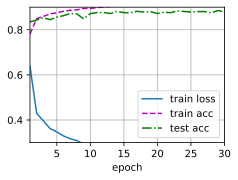

In [ ]:
num_epochs = 30
mu.train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer)

## Evaluation

In [ ]:
def accuracy(y_hat, y):  #y_hat is a matrix; 2nd dimension stores prediction scores for each class.
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # Predicted class is the index of max score         
    cmp = (y_hat.type(y.dtype) == y)  # because`==` is sensitive to data types
    return float(torch.sum(cmp)) # Taking the sum yields the number of correct predictions.

In [ ]:
class Accumulator:  
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n # [0, 0, ..., 0]
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
def evaluate_accuracy(net, data_iter): 
    """Compute the accuracy for a model on a dataset."""
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    for _, (X, y) in enumerate(data_iter):
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [ ]:
evaluate_accuracy(net, train_iter)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.9412666666666667

In [ ]:
evaluate_accuracy(net, test_iter)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.8793